# One Shot Learning for Computing Face Similarities

In [1]:
import os
import re
import pickle
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import face_recognition

from utilities import face_detect, face_draw

from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

import tensorflow as tf
from utilities.pca_plotter import PCAPlotter

## Create Datasets

In [2]:
np.random.seed(42) 
create = False

In [3]:
def load_images(images_folder, n_persons, n_samples, face_size=(100,100),
                search_limit=10, train_persons_list=[], diagnose=False):
    '''
    images_folder: images folder to load images
    '''
    # init info holders
    X_images = []
    X_embeds = []
    y = []
    videos_dict = dict()
    persons_dict = dict()
    failed_persons = []
    # init counters
    label = 0
    count = 0
    trial = 0
    
    # get names of all available persons
    persons = [folder for folder in os.listdir(images_folder) \
               if os.path.isdir(os.path.join(images_folder,folder))]
    # load a random person's data
    while len([*persons_dict]) < n_persons:
        person = np.random.choice(persons, 1)[0]
        if person in [*persons_dict] or person in train_persons_list or person in failed_persons:
            print(person,'was checked before!')
            continue
        print('- loading data for: ' + person)
        videos_path = os.path.join(images_folder, person)
        videos = os.listdir(videos_path)
        person_images = []
        person_embeds = []
        frame_sample_list = []
        while len(person_images) < n_samples and trial < search_limit:
            trial+=1
            video_sample = np.random.choice(videos, 1)[0]
            frames_path = os.path.join(videos_path, video_sample)
            frames = os.listdir(frames_path)
            frame_sample = np.random.choice(frames, 1)[0]
            if frame_sample in frame_sample_list:
                print('     (',frame_sample,'frame was used before!)')
                continue
            #person_dict[count] = (person, video)
            frame_path = os.path.join(frames_path, frame_sample)
            frame_image = cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB)
            face_output = face_detect.detect_faces_in_images(frame_path,
                                                            model='onnx',
                                                            lib='pil',
                                                            report=False,
                                                            show_images=diagnose,
                                                            save_images=False,
                                                            label_faces=True,
                                                            show_landmarks=False,
                                                            show_axes=False,
                                                            return_option='dict')

            face_locations = face_output['location']
            face_embeddings = face_output['embedding']
            
            #face_locations_r = read_face_locations(frame_path)
            #report_dict = {'process_time':0,'labels_probs':0, 'channels':'rgb'}
            #labeled_image = face_draw.face_locations(frame_image,report_dict,face_locations, None, show_points=True)
            #cv2.imshow('output',labeled_image)
            #cv2.waitKey(0)            
            #print(face_locations, face_locations_r)
            print('   - frame file: {0} - (number of faces: {1})'.format(frame_sample,len(face_locations)))
            if len(face_locations) == 1:
                # face image
                top,right,bottom,left = face_locations[0]
                face_image = frame_image[top:bottom,left:right]
                if diagnose:
                    cv2.imshow('output',cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))
                    cv2.waitKey(0)
                # try to crop resize the image
                try:
                    face_image = cv2.resize(face_image, face_size)
                # if error, then take another trial
                except:
                    continue
                if diagnose:
                    cv2.imshow('output',cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))
                    cv2.waitKey(0)
                person_images.append(face_image)
                # face embed
                face_embed = np.expand_dims(face_embeddings[0], axis=1)
                person_embeds.append(face_embed)
                # add data
                frame_sample_list.append(frame_sample)
                y.append(label)

        print('     (number of trials: {0} - number of samples: {1})'.format(trial, len(person_images)))
        if trial == search_limit and len(person_images) != n_samples:
            print("    ", person, "search limit was reached!. Look for another person's data")
            failed_persons.append(person)
        else:
            try:
                X_images.append(np.stack(person_images))
                X_embeds.append(np.stack(person_embeds))
            except ValueError as e:
                print('Error: ', e)
                #print("error - person_images: ", person_images)
            persons_dict[person] = [count, count+n_samples-1]
            count+=n_samples
            label+=1
        trial=0
    if diagnose: cv2.destroyAllWindows()
    X_images = np.stack(X_images)
    X_embeds = np.stack(X_embeds)
    y = np.vstack(y)
    print('selected persons:', [*persons_dict])
    return X_images, X_embeds, y, persons_dict

In [4]:
images_path = 'input/frame_images_DB'
n_persons = 100
n_samples = 20
trials = 100
face_size = (100,100)

if create:    
    X_images_train, X_embeds_train, y_train, persons_dict_train = load_images(images_path, n_persons, n_samples, 
                                                                          face_size, trials, diagnose=False)

In [5]:
if create:
    file_name = "train_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

    with open("output/train_test_data/"+file_name, "wb") as f:
        pickle.dump((X_images_train, X_embeds_train, y_train, persons_dict_train),f)

In [6]:
if create:
    n_persons = 20
    X_images_test, X_embeds_test, y_test, persons_dict_test = load_images(images_path, n_persons, n_samples, 
                                                                      face_size, trials, diagnose=False,
                                                                      train_persons_list=[*persons_dict_train])

In [7]:
if create:
    file_name = "test_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

    with open("output/train_test_data/"+file_name, "wb") as f:
        pickle.dump((X_images_test, X_embeds_test, y_test, persons_dict_test),f)

## Loading Datasets

In [8]:
n_persons = 1000
n_samples = 2
train_file_name = "train_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)

with open("output/train_test_data/"+train_file_name, "rb") as f:
    (X_images_train, X_embeds_train, y_train, persons_dict_train) = pickle.load(f)
    
n_persons = 100
n_samples = 2
test_file_name = "test_npersons_{}_nsamples_{}.pickle".format(n_persons, n_samples)
    
with open("output/train_test_data/"+test_file_name, "rb") as f:
   (X_images_test, X_embeds_test, y_test, persons_dict_test) =  pickle.load(f)

In [9]:
print('train: ', [*persons_dict_train])
print('test: ', [*persons_dict_test])

train:  ['Sarah_Weddington', 'James_Kopp', 'Frank_Abagnale_Jr', 'Aleksander_Kwasniewski', 'Gabrielle_Union', 'Peter_Max', 'Theresa_Gattung', 'Wolfgang_Schneiderhan', 'Warren_Buffett', 'Tim_Matheson', 'Aaron_Eckhart', 'Akmal_Taher', 'Takeo_Fukui', 'Martin_Landau', 'Jane_Pauley', 'Ralph_Nader', 'Richard_Harris', 'Patrice_Chereau', 'Caroline_Kennedy', 'Patti_Labelle', 'Adrien_Brody', 'Charlton_Heston', 'Nadia_Petrova', 'Harrison_Ford', 'Tian_Liang', 'Tom_McClintock', 'Gary_Forsee', 'Leticia_Van_de_Putte', 'Nick_Reilly', 'Paul_Krueger', 'William_Bratton', 'Clay_Aiken', 'Zoran_Djindjic', 'Alex_King', 'Ilan_Goldfajn', 'Janis_Ruth_Coulter', 'Maria_Guida', 'Maria_Bello', 'Lance_Bass', 'Marion_Barry', 'Barbara_Becker', 'Nick_Markakis', 'Natalie_Stewart', 'Jane_Fonda', 'Prince_Philippe', 'Zhong_Nanshan', 'Vivica_Fox', 'Elgin_Baylor', 'Dave_Barr', 'Vincent_Gallo', 'James_Traficant', 'Robert_Nardelli', 'Terry_McAuliffe', 'Ricardo_Lopez_Murphy', 'Amy_Brenneman', 'Jason_Biggs', 'Chris_Thomas', 'Cath

In [10]:
images_shape = X_images_train[0][0].shape
embeds_shape = X_embeds_train[0][0].shape

print('- images shape: {} - embeddings shape: {}'.format(images_shape, embeds_shape))

- images shape: (100, 100, 3) - embeddings shape: (128, 1)


## Get Functions

### Get Batch

In [11]:
def get_pairs(batch_size=None, train=True, embed=False, normalize=False, flatten=False,
              flip_same=False, do_shuffle=True):
    """ Create batch size pairs (first half: different persons - second half: same persons)"""
    
    # select data
    if train:
        if embed:
            X =  X_embeds_train
            flip_same = False
            normalize = False
            flatten = False
        else:
            X = X_images_train
    else:
        if embed:
            X =  X_embeds_test
            flip_same = False
            normalize=False
        else:
            X = X_images_test

    # if batch is not defined then take all examples (one for each person)
    if batch_size == None:
        batch_size = X.shape[0]
        
    # extract shape parameters
    if len(X.shape) == 5:
        n_persons, n_examples, h, w, n_channels = X.shape
        shape = (batch_size, h, w, n_channels)
        dtype = int
    else: 
        n_persons, n_examples, h, n_channels = X.shape
        shape = (batch_size, h, n_channels)
        dtype = float
        
    assert n_persons >= batch_size, "n_persons ({}) should be >= batch_size ({})".format(n_persons, 
                                                                                         batch_size)
    # sample diffirent persons (without replacement) based on the batch size
    persons = np.random.choice(n_persons, size=(batch_size,),replace=False)
    # initialize a pairs of a batch size
    pairs = [np.zeros(shape, dtype=dtype) for i in range(2)] # images int !!!!!!!!!
    # initialize targets
    targets = np.zeros((batch_size,))
    # second half is when the person is the same! 
    targets[batch_size//2:] = 1
    
    # loop through persons
    for i in range(batch_size):
        person_1 = persons[i]
        # sample two different examples from n_examples (without replacement)
        idx_1, idx_2 = np.random.choice(n_examples, size=(2,), replace=False)
        # save 1st example for this person 
        pairs[0][i] = X[person_1, idx_1]
        # check if we passed half of the batch size
        if i >= batch_size//2:
            # if true then take the same person again!
            person_2 = person_1
            if flip_same:
                pairs[1][i] = np.flip(X[person_2, idx_2],axis=1)
            else:
                pairs[1][i] = X[person_2, idx_2]
        else:
            # else take another person
            person_2 = (person_1 + np.random.randint(1,n_persons)) % n_persons
            pairs[1][i] = X[person_2, idx_2]
        
    if normalize:
        pairs[0] = pairs[0]/255
        pairs[1] = pairs[1]/255
        
    # flatten
    if flatten:
        shape = (batch_size, h*w*n_channels)
        pairs[0] = np.reshape(pairs[0], shape)
        pairs[1] = np.reshape(pairs[1], shape)
        
    # shuffle
    if do_shuffle:
        pairs[0], pairs[1], targets = shuffle(pairs[0], pairs[1], targets)
    
    return pairs, targets    

### Get Oneshot

In [12]:
def get_oneshot(N, train=False, embed=False, person=None, report=False, 
                flip_same=False, normalize=False, do_shuffle=True):
    """ Create pairs of test image """
        
    # select data
    if train:
        persons_dict = persons_dict_train
        if embed:
            X =  X_embeds_train
            flip_same = False
            normalize=False
        else:
            X = X_images_train
    else:
        persons_dict = persons_dict_test
        if embed:
            X =  X_embeds_test
            flip_same = False
            normalize=False
        else:
            X = X_images_test
        
    # extract shape parameters
    if len(X.shape) == 5:
        n_persons, n_examples, h, w, n_channels = X.shape
        #shape = (N, h, w, n_channels)
    else: 
        n_persons, n_examples, h, n_channels = X.shape
        #shape = (N, h, n_channels)
        
    assert n_persons >= N, "n_persons ({}) should be >= N ({})".format(n_persons, N)
    # sample persons N-times (based on the N-Way) (without replacement - difference persons)
    persons = np.random.choice(n_persons, size=(N,), replace=False)
    if report: print('selected persons:', persons)
    # sample N times examples (an example for each person)
    examples = np.random.randint(0, n_examples, size=(N,))
    if report: print('selected examples:', examples)
    
    # check if a person was specified
    if person is not None:
        # find specific person index as a true person
        true_person = [*persons_dict].index(person)
        # check if true person is not in the list
        if true_person in persons:
            # if in the list, then find its key
            true_person_key = np.where(persons==true_person)[0][0]
        # if not in the list then add as first
        else:
            persons[0] = true_person
            true_person_key = 0
    else:
        # take the first person as a true person
        true_person = persons[0]
        true_person_key = 0 
    if report: print('selected person: name:{}, index:{}, key:{}'.format(person, true_person, true_person_key))
    if report: print('selected persons:', persons)
    
    # sample two different examples from n_examples (without replacement)
    ex1, ex2 = np.random.choice(n_examples, size=(2,), replace=False)
    if report: print('selected true person examples:', ex1, ex2)
    # copy true person (1st sampled example) image N times
    test_image = np.asarray([X[true_person, ex1]]*N)#.reshape(N, w, h, n_channels)
    # copy persons images (sampled exampled - including true person)
    support_set = X[persons, examples, :, :]
    if report: print("test images (true person N times) and support images (inc. 1 true person) were created")
    
    # change the example for the true person to the second one (assures diff examples!)
    if not embed and flip_same:
        support_set[true_person_key] = np.flip(X[true_person, ex2],axis=1)
    else:
        support_set[true_person_key] = X[true_person, ex2]
    
    if normalize:
        if embed:
            normalizer = Normalizer(norm="L2") # does not need fit
            test_image = normalizer.trasform(test_image) 
            support_set = normalizer.trasform(support_set)
        else:
            test_image = test_image/255
            support_set = support_set/255
        
    # create target values
    targets = np.zeros((N,))
    
    # edit test image label
    targets[true_person_key] = 1
    
    # shuffle
    if do_shuffle:
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
    
    # create pair of images
    pairs = [test_image, support_set]
    
    return pairs, targets

### Triplets

In [13]:
def get_triplets(batch_size=None, train=True, embed=False, normalize=False, flatten=False,
                 flip_same=False, do_shuffle=True):
    """ Create batch size pairs (first half: different persons - second half: same persons)"""
    
    # select data
    if train:
        if embed:
            X =  X_embeds_train
            flip_same = False
            normalize=False
        else:
            X = X_images_train
    else:
        if embed:
            X =  X_embeds_test
            flip_same = False
            normalize=False
        else:
            X = X_images_test

    # if batch is not defined then take all examples (one for each person)
    if batch_size == None:
        batch_size = X.shape[0]
        
    # extract shape parameters
    if len(X.shape) == 5:
        n_persons, n_examples, h, w, n_channels = X.shape
        shape = (batch_size, h, w, n_channels)
        dtype = int
    else: 
        n_persons, n_examples, h, n_channels = X.shape
        shape = (batch_size, h, n_channels)
        dtype = float
        
    assert n_persons >= batch_size, "n_persons ({}) should be >= batch_size ({})".format(n_persons, 
                                                                                         batch_size)
    # sample diffirent persons (without replacement) based on the batch size
    persons = np.random.choice(n_persons, size=(batch_size,),replace=False)
    # initialize triplets of a batch size
    triplets = [np.zeros(shape, dtype=dtype) for i in range(3)]
    
    # loop through persons
    for i in range(batch_size):
        anchor_person = persons[i]
        # sample two different examples from n_examples (without replacement)
        idx_1, idx_2 = np.random.choice(n_examples, size=(2,), replace=False)
        # save 1st example for this person as anchor
        triplets[0][i] = X[anchor_person, idx_1]
        # take the same person as a positive example
        positive_person = anchor_person
        if flip_same:
            triplets[1][i] = np.flip(X[positive_person, idx_2],axis=1)
        else:
            triplets[1][i] = X[positive_person, idx_2]
        # take another person
        negative_person = (anchor_person + np.random.randint(1,n_persons)) % n_persons
        triplets[2][i] = X[negative_person, idx_2]
        
    if normalize:
        triplets[0] = triplets[0]/255
        triplets[1] = triplets[1]/255
        triplets[2] = triplets[2]/255
        
    # flatten
    if flatten:
        shape = (batch_size, h*w*n_channels)
        triplets[0] = np.reshape(triplets[0], shape)
        triplets[1] = np.reshape(triplets[1], shape)
        triplets[2] = np.reshape(triplets[2], shape)
        
    # shuffle
    if do_shuffle:
        triplets[0], triplets[1], triplets[2] = shuffle(triplets[0], triplets[1], triplets[2])
    
    return triplets

## Visualization

### Functions

In [14]:
def concat_images(X, targets):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    n_examples, h, w, n_channels = X.shape
    n = np.ceil(np.sqrt(n_examples)).astype("int8")
    img = np.ones((n*w, n*h, n_channels)).astype("int8")*255
    x = 0
    y = 0
    for example in range(n_examples):
        img[x*w:(x+1)*w,y*h:(y+1)*h,:] = X[example]
        cv2.putText(img[x*w:(x+1)*w,y*h:(y+1)*h,:], '{}'.format(int(targets[example])), (50,50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def show_Nway(pairs, targets):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,200))
    ax1.imshow(pairs[0][1])
    img = concat_images(pairs[1], targets)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def show_pairs(example_pairs, example_targets, deflatten=False):
    n = len(example_pairs[0])
    fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(5,n*2))
    for row in range(n):
        for col in range(2):
            if deflatten:
                axs[row,col].imshow(np.reshape(example_pairs[col][row], (100,100,3)))#, cmap='binary')
            else:
                axs[row,col].imshow(example_pairs[col][row])
            if col == 1:
                axs[row,col].annotate(xy=(100//2,100//2), s=str(int(example_targets[row])), c='w', fontsize=18)
            axs[row,col].set_xticks([])
            axs[row,col].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
def show_triplets(triplets, deflatten=False):
    n = len(triplets[0])
    fig, axs = plt.subplots(nrows=n, ncols=3, figsize=(5,n*3))
    for row in range(n):
        for col in range(3):
            if deflatten:
                axs[row,col].imshow(np.reshape(triplets[col][row], (100,100,3)))#, cmap='binary')
            else:
                axs[row,col].imshow(triplets[col][row])
            axs[row,col].set_xticks([])
            axs[row,col].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

### Example 1: show batch

In [15]:
example_pairs, example_targets = get_pairs(batch_size=32, train=True, embed=False, flatten=True)

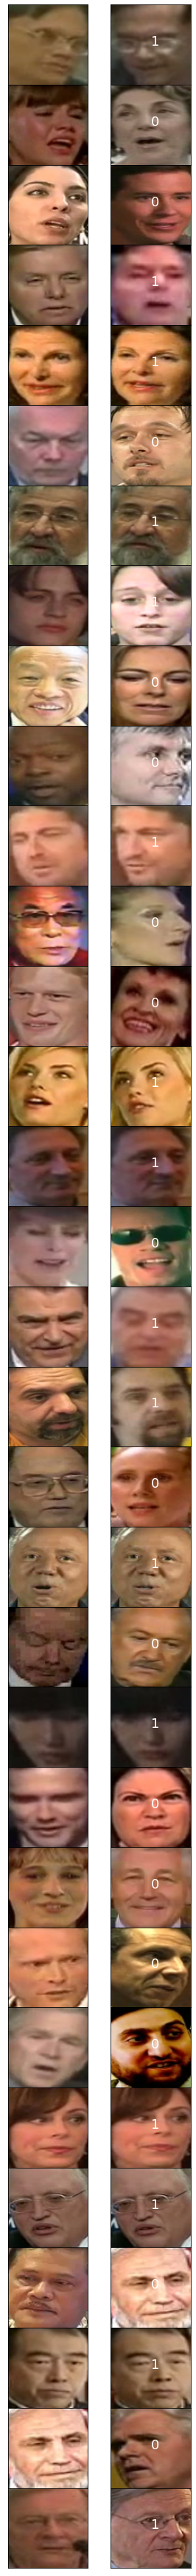

In [16]:
show_pairs(example_pairs, example_targets, deflatten=True)

### Example 2: show oneshot

In [17]:
example_pairs, example_targets = get_oneshot(N=9, train=True, embed=False, normalize=False)

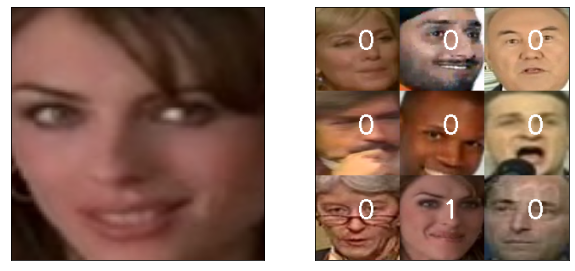

In [18]:
show_Nway(example_pairs, example_targets)

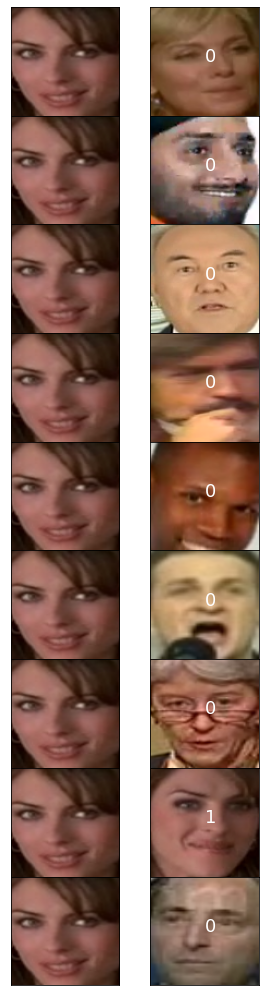

In [19]:
show_pairs(example_pairs, example_targets)

### Example 3: show triplets

In [20]:
example_triplets = get_triplets(batch_size=32, do_shuffle=True, flatten=True, flip_same=True)

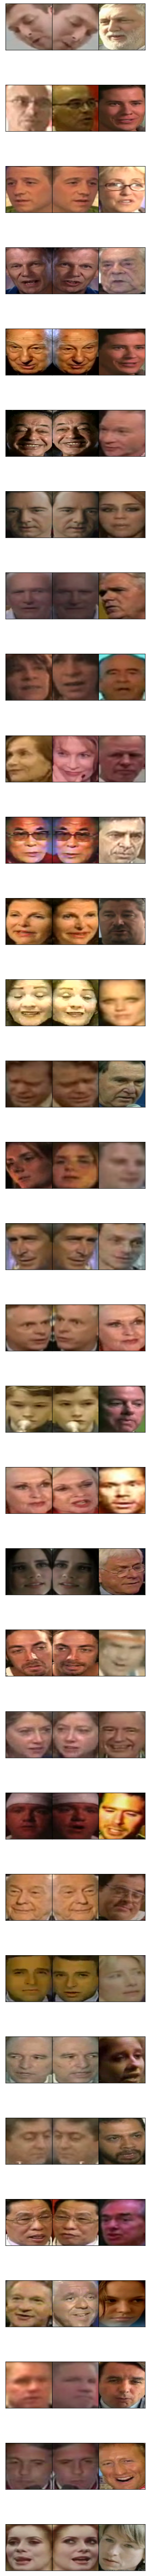

In [21]:
show_triplets(example_triplets, deflatten=True)

##  Test Oneshot Model

In [39]:
def test_oneshot(model, N, k, train=False, embed=False, normalize=False, do_shuffle=True, verbose=False,
                 combine=False):
    """ Test average one-shot learning accuracy based on N-way
    Arguments:
    - model: Siamese Network
    - N: Number of pairs (at which only one pair matches) to be tested in each one prediction test
    - k: Number of prediction tests to perform
    - train: Boolean, True if training and False if testing
    - verbose: Boolean.
    """
    # initialize number of correct predictions
    n_correct = 0
    for i in range(k):
        inputs, targets = get_oneshot(N, train, embed=embed, normalize=normalize, do_shuffle=do_shuffle)
        if combine:
             inputs = combine_pairs(inputs)
        probs = model.predict(inputs)
        print(probs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = n_correct/k
    if verbose:
        text = "train" if train else "test"
        print("[{}] oneshot learning accuracy: {}% (evaluated by {} N-Way for {} times)".format(text, 
                                                                            int(100*percent_correct), 
                                                                                            N, k))
    return percent_correct

## Test Sklearn Classifiers

In [85]:
def combine_pairs(X, orientation='v'):
    
    shape = list(X[0].shape)
    
    if orientation == 'v':
        shape[1] = shape[1]*2
    elif orientation == 'h':
        shape[2] = shape[2]*2
        
    shape = tuple(shape)
    #print(X[0].shape)
    X_stacked = np.ones(shape).astype("float")
    
    for i in range(shape[0]):
        if orientation == 'h':
            X_stacked[i] = cv2.hconcat([X[0][i], X[1][i]])
        elif orientation == 'v':
            X_stacked[i] = cv2.vconcat([X[0][i], X[1][i]])
    return X_stacked[:,:,0]

def test_model(model, param_grid=None, cv=5, embed=True, do_shuffle=True, normalize=False, combine=True):

    X_train, y_train = get_pairs(1000, train=True, embed=embed, 
                                 normalize=normalize, do_shuffle=do_shuffle)
    X_test, y_test = get_pairs(100, train=False, embed=embed, 
                                 normalize=normalize, do_shuffle=do_shuffle)
    if combine:
        X_train = combine_pairs(X_train, orientation='v')
        X_test = combine_pairs(X_test, orientation='v')

    if not param_grid:
        model = model.fit(X_train, y_train)
    else:
        model_grid = GridSearchCV(model, param_grid, cv=cv)
        model_grid = model_grid.fit(X_train, y_train)
    
        for test_score, parameters in zip(model_grid.cv_results_['mean_test_score'],
                                          model_grid.cv_results_['params']):
            print('mean score: {0:.4f} - parameters: {1}'.format(test_score, parameters))
        print('Best: ', model_grid.best_params_, model_grid.best_score_)
        
        model = model_grid.best_estimator_
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # train score
    acc_train = round(accuracy_score(y_train, y_train_pred)*100)
    precision_train = round(precision_score(y_train, y_train_pred)*100, 2)
    recall_train = round(recall_score(y_train, y_train_pred)*100, 2)
    scores_train = [acc_train, precision_train, recall_train]
    cm_train = confusion_matrix(y_train, y_train_pred)
    # test scores
    acc_test = round(accuracy_score(y_test, y_test_pred)*100, 2)
    precision_test = round(precision_score(y_test, y_test_pred)*100, 2)
    recall_test = round(recall_score(y_test, y_test_pred)*100, 2)
    scores_test = [acc_test, precision_test, recall_test]
    cm_test = confusion_matrix(y_test, y_test_pred)
    # summarize
    print('[Train] Scores:\n{}'.format(scores_train, scores_test))
    print('[Train] Confusion Matrix:\n', cm_train)
    print(' [Test] Scores:\n{}'.format(scores_test))
    print(' [Test] Confusion Matrix:\n', cm_test)
    return scores_train, scores_test, model

In [76]:
results = pd.DataFrame(columns=['Model','Train Acc %','Test Acc'])
models = []

### Logistic Regression

In [31]:
train_score, test_score, LR_model = test_model(LogisticRegression(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'LogisticRegression','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(LR_model)

[Train] Scores:
[62.0, 62.08, 62.2]
[Train] Confusion Matrix:
 [[310 190]
 [189 311]]
 [Test] Scores:
[48.0, 47.83, 44.0]
 [Test] Confusion Matrix:
 [[26 24]
 [28 22]]


### K-Nearest Neighbour

In [32]:
param_grid = [{'n_neighbors':range(5,20)}]
train_score, test_score, KN_model = test_model(KNeighborsClassifier(), param_grid, cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'KNeighbors','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(KN_model)

mean score: 0.7750 - parameters: {'n_neighbors': 5}
mean score: 0.8060 - parameters: {'n_neighbors': 6}
mean score: 0.7800 - parameters: {'n_neighbors': 7}
mean score: 0.7990 - parameters: {'n_neighbors': 8}
mean score: 0.7720 - parameters: {'n_neighbors': 9}
mean score: 0.7940 - parameters: {'n_neighbors': 10}
mean score: 0.7670 - parameters: {'n_neighbors': 11}
mean score: 0.7910 - parameters: {'n_neighbors': 12}
mean score: 0.7740 - parameters: {'n_neighbors': 13}
mean score: 0.7870 - parameters: {'n_neighbors': 14}
mean score: 0.7610 - parameters: {'n_neighbors': 15}
mean score: 0.7730 - parameters: {'n_neighbors': 16}
mean score: 0.7600 - parameters: {'n_neighbors': 17}
mean score: 0.7790 - parameters: {'n_neighbors': 18}
mean score: 0.7630 - parameters: {'n_neighbors': 19}
Best:  {'n_neighbors': 6} 0.806
[Train] Scores:
[87.0, 81.66, 96.2]
[Train] Confusion Matrix:
 [[392 108]
 [ 19 481]]
 [Test] Scores:
[78.0, 71.88, 92.0]
 [Test] Confusion Matrix:
 [[32 18]
 [ 4 46]]


### DecisionTreeClassifier

In [33]:
train_score, test_score, DT_model = test_model(DecisionTreeClassifier(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'DecisionTree','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(DT_model)

[Train] Scores:
[100.0, 100.0, 100.0]
[Train] Confusion Matrix:
 [[500   0]
 [  0 500]]
 [Test] Scores:
[65.0, 63.64, 70.0]
 [Test] Confusion Matrix:
 [[30 20]
 [15 35]]


### RandomForestClassifier

In [34]:
param_grid = [{'n_estimators':range(200,1400,200)}]
train_score, test_score, RF_model = test_model(RandomForestClassifier(), param_grid, cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'RandomForest','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(RF_model)

mean score: 0.7090 - parameters: {'n_estimators': 200}
mean score: 0.7000 - parameters: {'n_estimators': 400}
mean score: 0.7100 - parameters: {'n_estimators': 600}
mean score: 0.7080 - parameters: {'n_estimators': 800}
mean score: 0.7220 - parameters: {'n_estimators': 1000}
mean score: 0.7260 - parameters: {'n_estimators': 1200}
Best:  {'n_estimators': 1200} 0.726
[Train] Scores:
[100.0, 100.0, 100.0]
[Train] Confusion Matrix:
 [[500   0]
 [  0 500]]
 [Test] Scores:
[86.0, 86.0, 86.0]
 [Test] Confusion Matrix:
 [[43  7]
 [ 7 43]]


### SVM

In [35]:
param_grid = [{'C':[5,6,7,8,9],'degree':[5,6,7,8,9],'kernel':['poly']}]
train_score, test_score, SVC_model = test_model(SVC(probability=True), param_grid, cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'SVC','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(SVC_model)

mean score: 0.8260 - parameters: {'C': 5, 'degree': 5, 'kernel': 'poly'}
mean score: 0.8330 - parameters: {'C': 5, 'degree': 6, 'kernel': 'poly'}
mean score: 0.8400 - parameters: {'C': 5, 'degree': 7, 'kernel': 'poly'}
mean score: 0.8390 - parameters: {'C': 5, 'degree': 8, 'kernel': 'poly'}
mean score: 0.8390 - parameters: {'C': 5, 'degree': 9, 'kernel': 'poly'}
mean score: 0.8280 - parameters: {'C': 6, 'degree': 5, 'kernel': 'poly'}
mean score: 0.8360 - parameters: {'C': 6, 'degree': 6, 'kernel': 'poly'}
mean score: 0.8420 - parameters: {'C': 6, 'degree': 7, 'kernel': 'poly'}
mean score: 0.8430 - parameters: {'C': 6, 'degree': 8, 'kernel': 'poly'}
mean score: 0.8430 - parameters: {'C': 6, 'degree': 9, 'kernel': 'poly'}
mean score: 0.8280 - parameters: {'C': 7, 'degree': 5, 'kernel': 'poly'}
mean score: 0.8420 - parameters: {'C': 7, 'degree': 6, 'kernel': 'poly'}
mean score: 0.8420 - parameters: {'C': 7, 'degree': 7, 'kernel': 'poly'}
mean score: 0.8410 - parameters: {'C': 7, 'degree':

### MLPClassifier

In [36]:
param_grid = [{'hidden_layer_sizes':[800,1000,1200],'max_iter':[1000],'alpha':[0.001]}]
train_score, test_score, MLP_model = test_model(MLPClassifier(), param_grid, cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'MLP','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(MLP_model)

mean score: 0.8150 - parameters: {'alpha': 0.001, 'hidden_layer_sizes': 800, 'max_iter': 1000}
mean score: 0.8200 - parameters: {'alpha': 0.001, 'hidden_layer_sizes': 1000, 'max_iter': 1000}
mean score: 0.8260 - parameters: {'alpha': 0.001, 'hidden_layer_sizes': 1200, 'max_iter': 1000}
Best:  {'alpha': 0.001, 'hidden_layer_sizes': 1200, 'max_iter': 1000} 0.826
[Train] Scores:
[100.0, 100.0, 100.0]
[Train] Confusion Matrix:
 [[500   0]
 [  0 500]]
 [Test] Scores:
[82.0, 82.0, 82.0]
 [Test] Confusion Matrix:
 [[41  9]
 [ 9 41]]


### GaussianProcessClassifier

In [37]:
train_score, test_score, GP_model = test_model(GaussianProcessClassifier(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'GaussianProcess','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(GP_model)

[Train] Scores:
[86.0, 84.99, 87.2]
[Train] Confusion Matrix:
 [[423  77]
 [ 64 436]]
 [Test] Scores:
[78.0, 79.17, 76.0]
 [Test] Confusion Matrix:
 [[40 10]
 [12 38]]


### AdaBoostClassifier

In [38]:
train_score, test_score, AB_model = test_model(AdaBoostClassifier(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'AdaBoost','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(AB_model)

[Train] Scores:
[78.0, 77.87, 78.8]
[Train] Confusion Matrix:
 [[388 112]
 [106 394]]
 [Test] Scores:
[40.0, 40.38, 42.0]
 [Test] Confusion Matrix:
 [[19 31]
 [29 21]]


### GaussianNB

In [39]:
train_score, test_score, GNB_model = test_model(GaussianNB(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'GaussianNB','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(GNB_model)

[Train] Scores:
[64.0, 62.99, 67.4]
[Train] Confusion Matrix:
 [[302 198]
 [163 337]]
 [Test] Scores:
[57.0, 57.78, 52.0]
 [Test] Confusion Matrix:
 [[31 19]
 [24 26]]


### QuadraticDiscriminantAnalysis

In [40]:
train_score, test_score, QDA_model = test_model(QuadraticDiscriminantAnalysis(), cv=5, embed=True, do_shuffle=True, normalize=False)
results = results.append({'Model':'QuadraticDiscriminantAnalysis','Train Acc %':train_score, 'Test Acc':test_score}, ignore_index=True)
models.append(QDA_model)

[Train] Scores:
[100.0, 100.0, 100.0]
[Train] Confusion Matrix:
 [[500   0]
 [  0 500]]
 [Test] Scores:
[89.0, 100.0, 78.0]
 [Test] Confusion Matrix:
 [[50  0]
 [11 39]]


/home/abugrin/PycharmProjects/MSc_SecutringGatheringByCV/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Final Evaluation

In [41]:
results

Model Train[Acc%,Prec%,Rec%] Test[Acc%,Prec%,Rec%]  \
0             LogisticRegression                    NaN                   NaN   
1                     KNeighbors                    NaN                   NaN   
2                   DecisionTree                    NaN                   NaN   
3                   RandomForest                    NaN                   NaN   
4                            SVC                    NaN                   NaN   
5                            MLP                    NaN                   NaN   
6                GaussianProcess                    NaN                   NaN   
7                       AdaBoost                    NaN                   NaN   
8                     GaussianNB                    NaN                   NaN   
9  QuadraticDiscriminantAnalysis                    NaN                   NaN   

              Test Acc            Train Acc %  
0  [48.0, 47.83, 44.0]    [62.0, 62.08, 62.2]  
1  [78.0, 71.88, 92.0]    [87.0, 81.66, 96.2]  
2  [65.0, 63.64, 70.0]  [100.0, 100.0, 100.0]  
3   [86.0, 86.0, 86.0]  [100.0, 100.0, 100.0]  
4  [88.0, 85.19, 92.0]  [100.0, 100.0, 100.0]  
5   [82.0, 82.0, 82.0]  [100.0, 100.0, 100.0]  
6  [78.0, 79.17, 76.0]    [86.0, 84.99, 87.2]  
7  [40.0, 40.38, 42.0]    [78.0, 77.87, 78.8]  
8  [57.0, 57.78, 52.0]    [64.0, 62.99, 67.4]  
9  [89.0, 100.0, 78.0]  [100.0, 100.0, 100.0]

In [64]:
def test_trained_models(models, names, train=False):
    
    for model,name in zip(models,names):
        n_persons = (X_images_test.shape[0]//2)+1
        N_ways = np.arange(0, n_persons, 5)        dist = face_recognition.face_distance(pairs[0][i], pairs[1][i])[0]
        sim = face_recognition.compare_faces(pairs[0][i], pairs[1][i], tolerance=0.02)[0]
        N_ways[0] = 1
        trials = 100
        test_type = 'Train' if train else 'Test'
        accs = []
        for N_way in N_ways:
            if train:
                accs.append(100*test_oneshot(model, N_way, trials, True, embed=True, normalize=False, combine=True))                
            else: 
                accs.append(100*test_oneshot(model, N_way, trials, False, embed=True, normalize=False, combine=True))
        plt.plot(N_ways, accs, label="{}.Acc: {}".format(test_type, name))
    
    plt.plot(N_ways, 100.0/N_ways, "r", label="Random guessing")
    plt.xlabel("Number of possible classes in one-shot task")
    plt.ylabel("% Accuracy")
    plt.title("One-Shot Learning - Models Comparison ({})".format(test_type))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

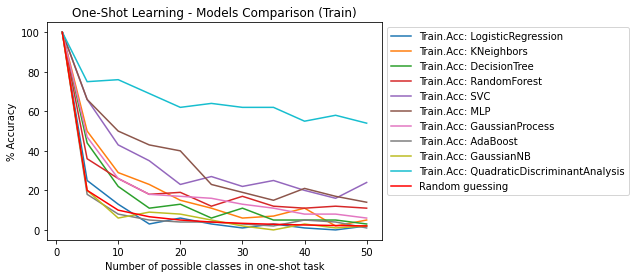

In [66]:
test_trained_models(models, list(results['Model']), train=True)

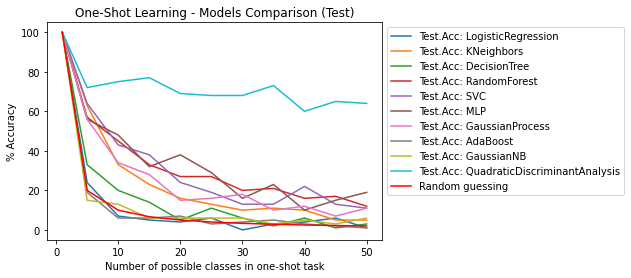

In [65]:
test_trained_models(models, list(results['Model']), train=False)

## Face Recognision Similaritym

In [151]:
from sklearn.base import BaseEstimator

class FaceSimilarity(BaseEstimator):
    def __init__(self, combine, min_dist=0.02):
        self.combine = combine
        self.min_dist = min_dist
        self.prediction = 0
    def fit(self, X, y=None): 
        return self
    def step_func(self, dist):
        if dist >= min_dist:
            return 0
        return 1
    def predict(self, X):
        prediction = []
        
        if self.combine:
            length = len(X)
        else:
            length = len(X[0])
        for i in range(length):
            if self.combine:
                face_embeddings_1 = np.array(X[i][:128]).reshape(128,1)
                face_embeddings_2 = np.array(X[i][128:]).reshape(128,1)
                dist = face_recognition.face_distance(face_embeddings_1, face_embeddings_2)[0]
                pred = step_func(dist)
            else:
                dist = face_recognition.face_distance(X[0][i], X[1][i])[0]
                pred = step_func(dist)
            prediction.append(pred)
        self.prediction = prediction
        return prediction
    def score(self):
        return sum(prediction)/len(prediction)

In [154]:
train_score, test_score, model = test_model(FaceSimilarity(combine=True),embed=True, do_shuffle=True, normalize=False, combine=True)

[Train] Scores:
[63.0, 68.97, 48.0]
[Train] Confusion Matrix:
 [[392 108]
 [260 240]]
 [Test] Scores:
[54.0, 59.09, 26.0]
 [Test] Confusion Matrix:
 [[41  9]
 [37 13]]


## Siamese Model (Pairs)

In [23]:
def init_weights(shape, dtype=None, name=None):
    return np.random.normal(loc=0.0, scale=1e-2, size=shape)

def init_bias(shape, dtype=None, name=None):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)

def get_conv(input_shape, name=None, model=None, api='sequential'):
    if api == 'functional': 
        if model == None:
            input_layer = keras.Input(input_shape)
            x_1 = layers.Conv2D(64, (10,10), activation='relu', kernel_regularizer=l2(2e-4), input_shape=input_shape,
                                kernel_initializer=init_weights, bias_initializer=init_bias)(input_layer)
            x_2 = layers.MaxPooling2D(strides=2)(x_1)
            x_3 = layers.Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias)(x_2)
            x_4 = layers.MaxPooling2D(strides=2)(x_3)
            x_5 = layers.Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias)(x_4)
            x_6 = layers.MaxPooling2D(strides=2)(x_5)
            x_7 = layers.Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias)(x_6)
            x_8 = layers.Flatten()(x_7)
            x_9 = layers.Dense(4096, activation='sigmoid', kernel_regularizer=l2(2e-4),
                                   kernel_initializer=init_weights, bias_initializer=init_bias)(x_8)
            encoded = keras.Model(inputs=input_layer, outputs=x_9, name=name)
            return encoded, input_layer
    elif api == 'sequential':
        input_layer = keras.Input(input_shape, name='{}_input_layer'.format(name))
        if model == None:
            model = keras.Sequential(name='sequential')
            model.add(layers.Conv2D(64, (10,10), activation='relu', kernel_regularizer=l2(2e-4), input_shape=input_shape,
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.MaxPooling2D(strides=2))
            model.add(layers.Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4),
                                kernel_initializer=init_weights, bias_initializer=init_bias))
            model.add(layers.Flatten())
            model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=l2(2e-4),
                                   kernel_initializer=init_weights, bias_initializer=init_bias))
            encoded = model(input_layer)
            return encoded, input_layer, model
        else:
            encoded = model(input_layer)
            return encoded, input_layer
    elif api == 'embeds':
        input_layer = keras.Input(input_shape, name='{}_input_layer'.format(name))
        if model == None:
            model = keras.Sequential(name='sequential')
            model.add(layers.Flatten())
            #model.add(layers.Dense(64, activation='relu'))
            #model.add(layers.Dense(512, activation='relu'))
            #model.add(layers.Dense(512, activation='sigmoid'))
            #model.add(layers.Dense(512, activation='sigmoid'))
            encoded = model(input_layer)
            return encoded, input_layer, model
        else:
            encoded = model(input_layer)
            return encoded, input_layer
        
    
def init_siamse_model(input_shape, api='sequential'):
    # encode
    left_encoded, left_input, model = get_conv(input_shape, name="left", api=api)
    right_encoded, right_input = get_conv(input_shape, name="right", model=model, api=api)
    # compute the absolute difference (cosine loss function)
    L1_layer = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]), name='abs_diff')
    L1_distance = L1_layer([left_encoded, right_encoded])
    # similarity score
    y = layers.Dense(1, activation='sigmoid', bias_initializer=init_bias, name='ouput')(L1_distance)
    # siamese network
    siamese_net = keras.Model(inputs=[left_input, right_input], outputs=y)
    return siamese_net

### Images Model

In [24]:
images_model = init_siamse_model((images_shape), api='sequential')
images_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input_layer (InputLayer)   [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
right_input_layer (InputLayer)  [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         27426112    left_input_layer[0][0]           
                                                                 right_input_layer[0][0]          
__________________________________________________________________________________________________
abs_diff (Lambda)               (None, 4096)         0           sequential[1][0]             

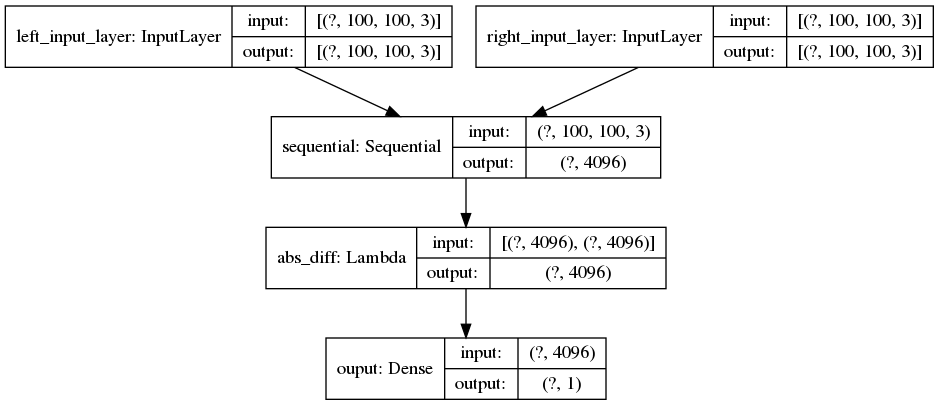

In [25]:
# requires: 1. pip install pydot and graphviz - 2. sudo apt-get install graphviz
keras.utils.plot_model(images_model, "mini_resnet.png", show_shapes=True)

In [26]:
optimizer  = keras.optimizers.Adam(lr=0.00006)
images_model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics='accuracy')
images_model.save_weights(os.path.join("output/model", "weights", "init_images_train_weights.h5"))

### Embeds Model

In [27]:
embeds_model = init_siamse_model((embeds_shape), api='embeds')
embeds_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input_layer (InputLayer)   [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
right_input_layer (InputLayer)  [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          0           left_input_layer[0][0]           
                                                                 right_input_layer[0][0]          
__________________________________________________________________________________________________
abs_diff (Lambda)               (None, 128)          0           sequential[0][0]           

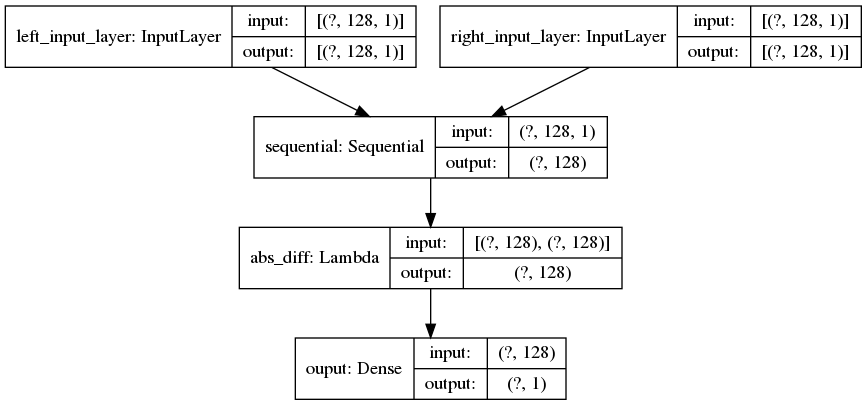

In [28]:
keras.utils.plot_model(embeds_model, "mini_resnet.png", show_shapes=True)

In [29]:
optimizer  = keras.optimizers.Adam(lr=0.00006)
embeds_model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics='accuracy')
embeds_model.save_weights(os.path.join("output/model", "weights", "init_embeds_train_weights.h5"))

## Siamese Network Training

In [30]:
def siamese_train(epochs=10, batch_size=64, train_type='batch', save_weights='final', eval_freq=2,
                  n_way=10, n_test=10, embed=False, normalize=False, do_shuffle=True, plot=True):
    
    test_batch_size = X_images_test.shape[0] # should not be higher than the n_persons in test data
    best = 0
    model_path = "output/model/"
    results = {'train_loss':[], 'train_acc':[],
               'test_loss':[], 'test_acc':[],
               'n_way_train_acc':[], 'n_way_test_acc':[]}
    
    print("starting oneshot training (evaluated by {} N-Way for {} times):".format(n_way, n_test))
    start_time = time.time()
    
    if embed:
        model = embeds_model
        model.load_weights(os.path.join(model_path, "weights", "init_embeds_train_weights.h5"))
        text = "embeds"
    else:
        model = images_model
        model.load_weights(os.path.join(model_path, "weights", "init_images_train_weights.h5"))
        text = "images"
        
    if normalize:
        text = 'nor_'+text
    text = text+'_bs{}_ep{}'.format(batch_size,epochs)
    
    if train_type == 'batch':
        text = 'batch_'+text
        n_persons = X_images_train.shape[0] #or X_embeds_train.shape[0]
        iters_per_epoch = n_persons//batch_size # equivalent to 1 epoch
        iters = epochs*iters_per_epoch
        print(" - epochs: {} (eq.iters: {}) - eval freq: {} - batch_size: {}".format(epochs,
                                                                                     iters,
                                                                                     eval_freq, 
                                                                                     batch_size))
        eval_freq = eval_freq*iters_per_epoch
        epochs = iters
    elif train_type == 'epoch':
        text = 'epoch_'+text
        iters_per_epoch = 1
        print(" - epochs: {} - eval freq: {} - batch_size: {}".format(epochs, eval_freq, batch_size))
        
    assert n_way <= test_batch_size, "n_way should be <= n_persons in test data"
    assert epochs >= eval_freq, "epcohs should be >= eval_freq"
    
    for epoch in range(1, epochs+1):        
            
        if train_type == 'epoch':
            X_train, y_train = get_pairs(None, train=True, embed=embed, 
                                         normalize=normalize, do_shuffle=do_shuffle)
            outputs = model.fit(X_train, y_train, batch_size, epochs=1, verbose=0, shuffle=False)
            outputs = [outputs.history['loss'][0],outputs.history['accuracy'][0]]
        elif train_type == 'batch':
            X_train, y_train = get_pairs(batch_size, train=True, embed=embed, 
                                         normalize=normalize, do_shuffle=do_shuffle)          
            outputs = model.train_on_batch(X_train, y_train)
            
        if save_weights == 'step':
            if train_type == 'batch': epoch_num = epoch//iters_per_epoch
            else: epoch_num = epoch
            model.save_weights(os.path.join(model_path, "weights", "{}_epoch_{}.h5".format(text,epoch_num)))
        
        if epoch % eval_freq == 0:
            
            results['train_loss'].append(outputs[0])
            results['train_acc'].append(outputs[1])

            X_test, y_test = get_pairs(test_batch_size, train=False, embed=embed, 
                                     normalize=normalize, do_shuffle=do_shuffle)
            outputs = model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)

            results['test_loss'].append(outputs[0])
            results['test_acc'].append(outputs[1])
            
            print("----------------------------------------------------------------------------------------")
            process_time = round((time.time()-start_time) / 60.0, 1)
            print("[{}mins] epoch: {} | train loss:{} | train acc:{} |".format(process_time, 
                                                                        epoch//iters_per_epoch, 
                                                                        round(results['train_loss'][-1],2),
                                                                        round(results['train_acc'][-1],2)))
            print("                   | test loss: {} | test acc: {} |".format(round(results['test_loss'][-1],2),
                                                                               round(results['test_acc'][-1],2)))
            
            nway_train_acc = test_oneshot(model, n_way, n_test, train=True, embed=embed, 
                                          normalize=normalize, do_shuffle=do_shuffle)
            nway_test_acc = test_oneshot(model, n_way, n_test, train=False, embed=embed, 
                                         normalize=normalize, do_shuffle=do_shuffle)

            print("                   | N-Way train acc:{} | N-Way test acc:{}".format(nway_train_acc, 
                                                                                       nway_test_acc))
            results['n_way_train_acc'].append(nway_train_acc)
            results['n_way_test_acc'].append(nway_test_acc)
            

            if nway_test_acc > best:
                print("               | best N-Way train acc: current={} | previous={})".format(nway_test_acc, 
                                                                                                best))
                best = nway_test_acc
    
    if plot:
        plt.plot(results['train_loss'], '-r', label='Train.loss')
        plt.plot(results['train_acc'], '-g', label='Train.Acc')
        plt.plot(results['test_loss'], ':r', label='Test.loss')
        plt.plot(results['test_acc'], ':g', label='Test.Acc')
        plt.plot(results['n_way_train_acc'], '-b', label='N-way.Train.Acc')
        plt.plot(results['n_way_test_acc'], ':b', label='N-way.Test.Acc')
        plt.ylim(0,1.1)
        plt.legend(bbox_to_anchor=(1, 1))
                
    if save_weights == 'final':
        model.save_weights(os.path.join(model_path, "weights", "{}_final.h5".format(text)))
    
    with open(os.path.join(model_path, "results", "{}_results.pickle".format(text)), "wb") as f:
        pickle.dump(results,f)
                  
    return results

## Training Embeds (without normalization)

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 280 (eq.iters: 840) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.68 | train acc:0.5 |
                   | test loss: 0.69 | test acc: 0.5 |
                   | N-Way train acc:0.66 | N-Way test acc:0.77
               | best N-Way train acc: current=0.77 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.68 | train acc:0.5 |
                   | test loss: 0.68 | test acc: 0.5 |
                   | N-Way train acc:0.71 | N-Way test acc:0.79
               | best N-Way train acc: current=0.79 | previous=0.77)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.66 | train acc:0.5 |
                   | test loss: 0.66 | test acc: 0.5 |
      

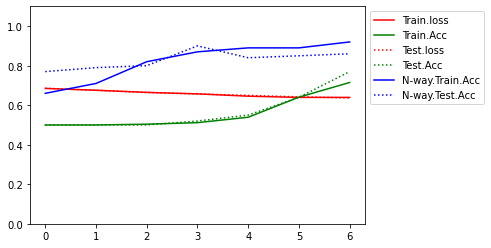

In [31]:
batch_embeds_bs256_ep280_resutls = siamese_train(epochs=280, batch_size=256, train_type='batch', eval_freq=40,
                                                 n_way=10, n_test=100, embed=True, normalize=False, do_shuffle=True)

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 280 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.1mins] epoch: 40 | train loss:0.68 | train acc:0.5 |
                   | test loss: 0.68 | test acc: 0.5 |
                   | N-Way train acc:0.84 | N-Way test acc:0.72
               | best N-Way train acc: current=0.72 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.67 | train acc:0.5 |
                   | test loss: 0.67 | test acc: 0.5 |
                   | N-Way train acc:0.86 | N-Way test acc:0.84
               | best N-Way train acc: current=0.84 | previous=0.72)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.65 | train acc:0.51 |
                   | test loss: 0.65 | test acc: 0.52 |
                   |

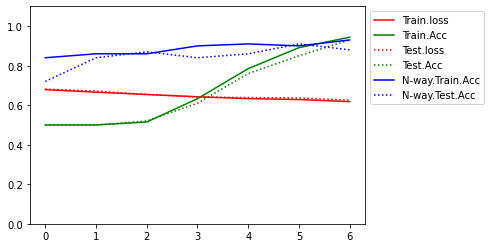

In [32]:
epcoh_embeds_bs256_ep280_resutls = siamese_train(epochs=280, batch_size=256, train_type='epoch', eval_freq=40,
                                                 n_way=10, n_test=100, embed=True, normalize=False, do_shuffle=True)

## Training Embeds (with normalization)

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 280 (eq.iters: 840) - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.68 | train acc:0.5 |
                   | test loss: 0.68 | test acc: 0.5 |
                   | N-Way train acc:0.68 | N-Way test acc:0.72
               | best N-Way train acc: current=0.72 | previous=0)
----------------------------------------------------------------------------------------
[0.1mins] epoch: 80 | train loss:0.67 | train acc:0.5 |
                   | test loss: 0.68 | test acc: 0.5 |
                   | N-Way train acc:0.78 | N-Way test acc:0.8
               | best N-Way train acc: current=0.8 | previous=0.72)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.66 | train acc:0.5 |
                   | test loss: 0.66 | test acc: 0.5 |
        

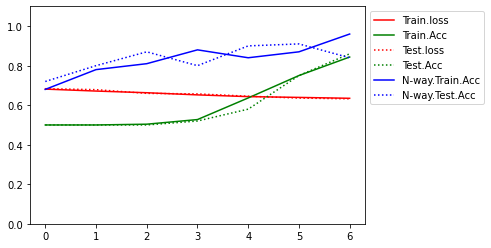

In [33]:
batch_nor_embeds_bs256_ep280_resutls = siamese_train(epochs=280, batch_size=256, train_type='batch', eval_freq=40,
                                                 n_way=10, n_test=100, embed=True, normalize=True, do_shuffle=True)

starting oneshot training (evaluated by 10 N-Way for 100 times):
 - epochs: 280 - eval freq: 40 - batch_size: 256
----------------------------------------------------------------------------------------
[0.0mins] epoch: 40 | train loss:0.68 | train acc:0.5 |
                   | test loss: 0.68 | test acc: 0.5 |
                   | N-Way train acc:0.76 | N-Way test acc:0.79
               | best N-Way train acc: current=0.79 | previous=0)
----------------------------------------------------------------------------------------
[0.2mins] epoch: 80 | train loss:0.67 | train acc:0.5 |
                   | test loss: 0.66 | test acc: 0.5 |
                   | N-Way train acc:0.85 | N-Way test acc:0.88
               | best N-Way train acc: current=0.88 | previous=0.79)
----------------------------------------------------------------------------------------
[0.3mins] epoch: 120 | train loss:0.65 | train acc:0.53 |
                   | test loss: 0.65 | test acc: 0.52 |
                   |

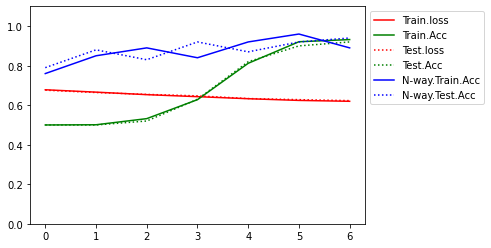

In [34]:
epcoh_nor_embeds_bs256_ep280_resutls = siamese_train(epochs=280, batch_size=256, train_type='epoch', eval_freq=40,
                                                 n_way=10, n_test=100, embed=True, normalize=True, do_shuffle=True)

## Load Model Weights

In [35]:
def test_trained_models(model=None, model_type="image"):

    weights_path = "output/model/weights"
    model_weights = [name for name in os.listdir(weights_path) if model_type in name and name[-3:] == '.h5']
    
    for i, model_weight in enumerate(model_weights, start=1):
        print("test {} - model: {}".format(i, model_weight))
        model.load_weights(os.path.join(weights_path, model_weight))
        
        if 'nor' in model_weight:
            normalize = True
        else:
            normalize = False
        
        if 'embed' in model_weight:
            embed = True
        else:
            embed = False
        
        n_persons = (X_images_test.shape[0]//2)+1
        N_ways = np.arange(0, n_persons, 5)
        N_ways[0] = 1
        trials = 10

        test_accs, train_accs, = [], []
        for N_way in N_ways:    
            train_accs.append(100*test_oneshot(model, N_way, trials, True, embed, normalize, verbose=False))
            test_accs.append(100*test_oneshot(model, N_way, trials, False, embed, normalize, verbose=False))
        
        fig,ax = plt.subplots(1, figsize=(10,5))
        ax.plot(N_ways, test_accs, "m", label="Test.Acc")
        ax.plot(N_ways, train_accs, "y", label="Train.Acc")
        ax.plot(N_ways, 100.0/N_ways, "g", label="Random guessing")
        plt.xlabel("Number of possible classes in one-shot task")
        plt.ylabel("% Accuracy")
        plt.title("One-Shot Learning ({})".format(model_weight))
        ax.legend(loc='upper right')
        plt.show()

test 1 - model: batch_nor_embeds_bs256_ep280_final.h5


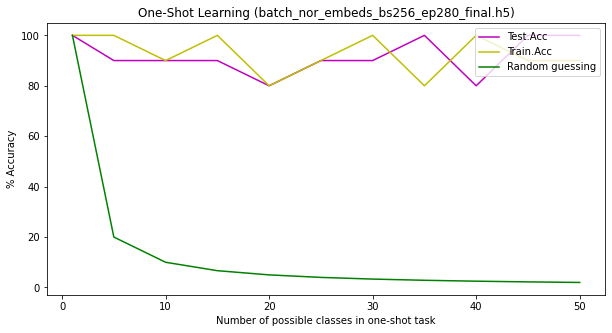

test 2 - model: batch_embeds_bs256_ep280_final.h5


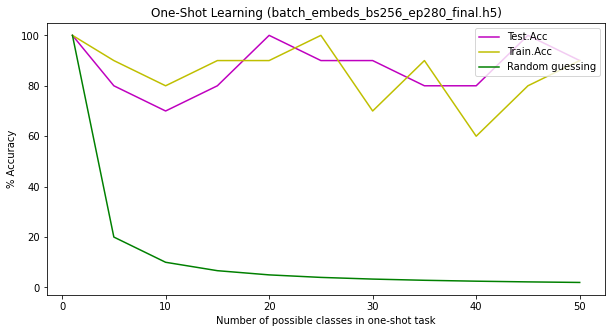

test 3 - model: init_embeds_train_weights.h5


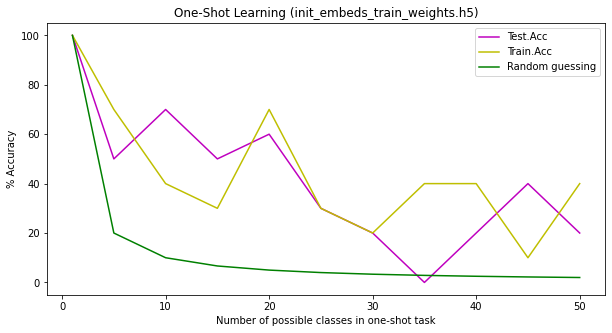

test 4 - model: epoch_embeds_bs256_ep280_final.h5


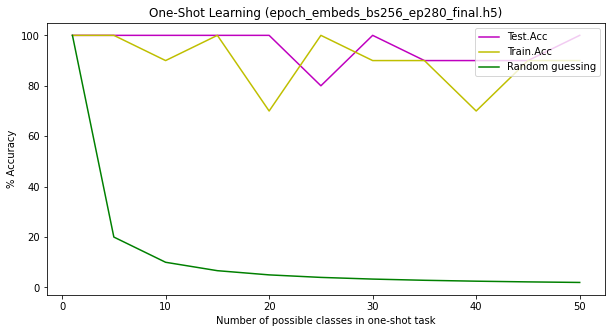

test 5 - model: epoch_nor_embeds_bs256_ep280_final.h5


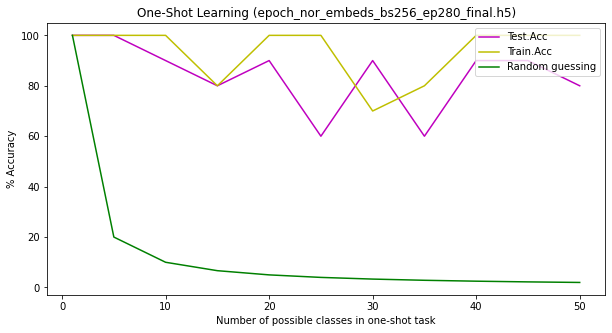

In [36]:
test_trained_models(embeds_model, model_type="embeds")

### Examples:

In [40]:
def load_model(model, weights):
    
    weights_path = "output/model/weights/" + weights
    model.load_weights(weights_path)
    #model.save("output/model/epoch_embeds_bs256_ep280_final.h5")
    return model
    
model = load_model(embeds_model,'epoch_embeds_bs256_ep280_final.h5')

In [44]:
pairs, targets = get_pairs(2, False, True, False)
pairs[0].shape

(2, 128, 1)

In [45]:
model.predict(pairs)

array([[0.5334038 ],
       [0.43678486]], dtype=float32)

In [37]:
np.expand_dims(pairs[0][0], axis=0).shape

(1, 128, 1)

## Siamese Network (Triplets)

In [297]:
input_shape

(30000,)

In [379]:
emb_size = 64
input_shape = (30000,)#images_shape # (784,) #(30000,)#embeds_shape

embedding_model = keras.models.Sequential([
    keras.layers.Dense(emb_size, activation='relu', input_shape=input_shape),
    keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                1920064   
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
Total params: 1,924,224
Trainable params: 1,924,224
Non-trainable params: 0
_________________________________________________________________


In [380]:
example = get_triplets(1,flatten=True)[0]
print(example.shape)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

(1, 30000)
[3.72362316e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.45856684e-27 4.57599236e-13
 2.73785600e-23 1.00000000e+00 1.10599697e-02 1.00000000e+00
 0.00000000e+00 4.61859860e-28 0.00000000e+00 1.00000000e+00
 3.15992183e-22 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 1.00000000e+00 1.01277445e-26
 0.00000000e+00 1.45681343e-37 3.85846113e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 9.92527723e-01
 6.46680593e-04 1.00000000e+00 1.45796537e-02 1.00000000e+00
 0.00000000e+00 9.99960601e-01 1.00000000e+00 1.00000000e+00
 1.04619531e-08 1.00000000e+00 5.05878599e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00000000e+00
 8.30107467e-14 1.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+00 1.86393639e-33 1.00000000e+00 1.00000000e+00]


In [381]:
input_anchor = keras.layers.Input(shape=input_shape)
input_positive = keras.layers.Input(shape=input_shape)
input_negative = keras.layers.Input(shape=input_shape)

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 30000)]      0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 30000)]      0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 30000)]      0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 64)           1924224     input_35[0][0]                   
                                                                 input_36[0][0]             

In [382]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)


def triplet_loss_1(alpha=0.2, emb_size=emb_size):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
        negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
        return tf.maximum(positive_dist - negative_dist + alpha, 0.)
    return loss

In [383]:
def data_generator(batch_size=256, emb_size=emb_size):
    while True:
        x = get_triplets(batch_size, embed=False, flatten=True, normalize=True)
        y = np.zeros((batch_size, 3*emb_size)) # useless !?
        yield x, y

In [384]:
batch_size = 256
epochs = 100
steps_per_epoch = int(X_images_train.shape[0]/batch_size)
print(X_images_train.shape, steps_per_epoch)

net.compile(loss=triplet_loss, optimizer='adam', metrics=['accuracy'])

(1000, 2, 100, 100, 3) 3


<IPython.core.display.Javascript object>


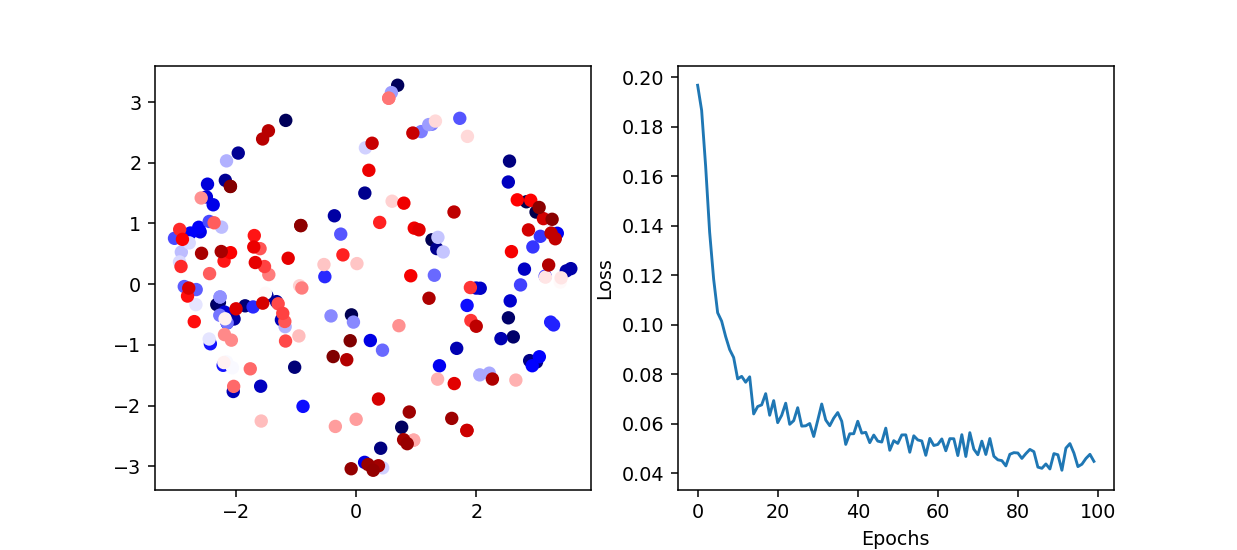

Epoch 1/100
3/3 [==============================] - 1s 203ms/step - loss: 0.1967 - accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 1s 216ms/step - loss: 0.1866 - accuracy: 0.0065
Epoch 3/100
3/3 [==============================] - 1s 199ms/step - loss: 0.1640 - accuracy: 0.0078
Epoch 4/100
3/3 [==============================] - 1s 203ms/step - loss: 0.1374 - accuracy: 0.0013
Epoch 5/100
3/3 [==============================] - 1s 264ms/step - loss: 0.1184 - accuracy: 0.0169
Epoch 6/100
3/3 [==============================] - 1s 192ms/step - loss: 0.1048 - accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 1s 217ms/step - loss: 0.1014 - accuracy: 0.0182
Epoch 8/100
3/3 [==============================] - 1s 218ms/step - loss: 0.0952 - accuracy: 0.0560
Epoch 9/100
3/3 [==============================] - 1s 246ms/step - loss: 0.0900 - accuracy: 0.0378
Epoch 10/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0868 - accuracy: 0.0312
E

Epoch 83/100
3/3 [==============================] - 1s 213ms/step - loss: 0.0480 - accuracy: 0.1042
Epoch 84/100
3/3 [==============================] - 1s 205ms/step - loss: 0.0497 - accuracy: 0.0872
Epoch 85/100
3/3 [==============================] - 1s 193ms/step - loss: 0.0488 - accuracy: 0.1003
Epoch 86/100
3/3 [==============================] - 1s 234ms/step - loss: 0.0425 - accuracy: 0.0898
Epoch 87/100
3/3 [==============================] - 1s 199ms/step - loss: 0.0420 - accuracy: 0.1341
Epoch 88/100
3/3 [==============================] - 1s 231ms/step - loss: 0.0438 - accuracy: 0.1458
Epoch 89/100
3/3 [==============================] - 1s 190ms/step - loss: 0.0418 - accuracy: 0.1940
Epoch 90/100
3/3 [==============================] - 1s 224ms/step - loss: 0.0480 - accuracy: 0.1888
Epoch 91/100
3/3 [==============================] - 1s 179ms/step - loss: 0.0475 - accuracy: 0.1732
Epoch 92/100
3/3 [==============================] - 1s 244ms/step - loss: 0.0412 - accuracy: 0.1458


In [385]:
%matplotlib notebook

_ = net.fit(
    data_generator(batch_size, emb_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[PCAPlotter(plt, embedding_model,
                          np.reshape(X_images_test,(200,30000)), 
                          y_test)]
)

<IPython.core.display.Javascript object>


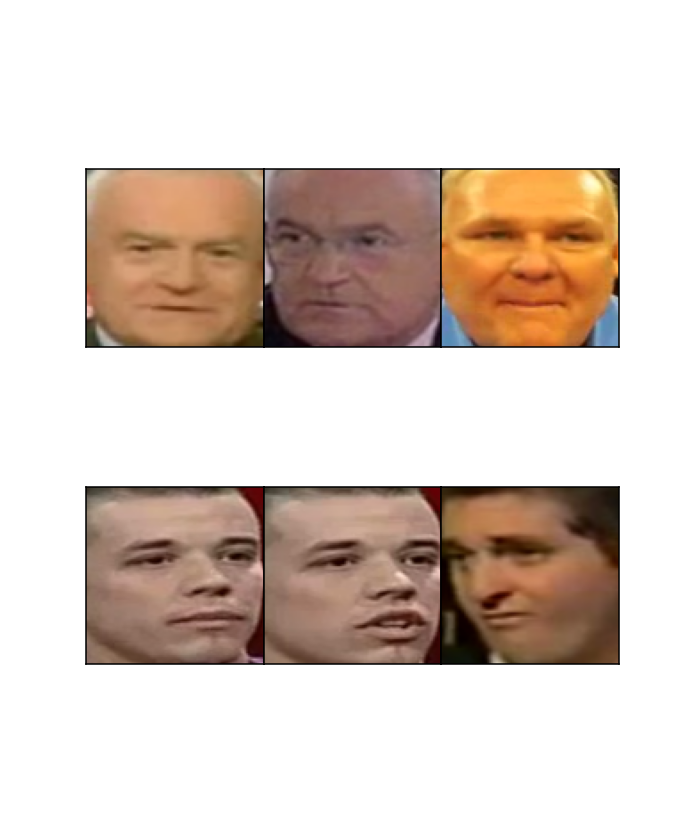

In [386]:
trip = get_triplets(2, flatten=True)
show_triplets(trip, deflatten=True)

In [390]:
result = net.predict(trip)
emb = result[0].reshape((3,64))
print(np.linalg.norm(emb[0]-emb[1],1))
print(np.linalg.norm(emb[0]-emb[2],1))

8.0
11.0


In [391]:
emb = result[1].reshape((3,64))
print(np.linalg.norm(emb[0]-emb[1],1))
print(np.linalg.norm(emb[0]-emb[2],1))

2.0
22.0


In [292]:
emb_size = 64
input_shape = (30000,)#images_shape # (784,) #(30000,)#embeds_shape

embedding_model = keras.models.Sequential([
    keras.layers.Dense(emb_size, activation='relu', input_shape=input_shape),
    keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 64)                1920064   
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
Total params: 1,924,224
Trainable params: 1,924,224
Non-trainable params: 0
_________________________________________________________________


In [225]:
example = get_triplets(1,flatten=True)[0]
print(example.shape)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

(1, 30000)
[1.66571361e-08 1.20613240e-17 1.00000000e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00 6.68097577e-10 8.13551853e-33
 2.54062257e-34 0.00000000e+00 2.28329482e-36 8.00211524e-08
 1.58013809e-05 1.00000000e+00 2.81477926e-33 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.89432502e-03 1.00000000e+00
 3.60499505e-33 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 5.27385820e-14
 1.00000000e+00 9.99999762e-01 8.69056609e-32 9.99913216e-01
 1.00000000e+00 1.00000000e+00 9.91412222e-01 1.00000000e+00
 1.00000000e+00 2.20228805e-16 1.00000000e+00 1.00000000e+00
 0.00000000e+00 1.00000000e+00 1.98792645e-22 1.00000000e+00
 1.00000000e+00 2.60736310e-23 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 0.00000000e+00 1.03413601e-21
 1.11486815e-26 2.02507926e-14 6.77837887e-38 9.77125729e-31
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 2.19151464e-35 2.62451572e-09 1.00000000e+00 0.00000000e+00]


In [294]:
input_pair_1 = keras.layers.Input(shape=input_shape)
input_pair_2 = keras.layers.Input(shape=input_shape)

embedding_pair_1 = embedding_model(input_pair_1)
embedding_pair_2 = embedding_model(input_pair_2)

concate = keras.layers.concatenate([embedding_pair_1, embedding_pair_2], axis=1)
output = keras.layers.Dense(1,activation='sigmoid')

net = keras.models.Model([input_pair_1, input_pair_2, concate], output)
net.summary()

AttributeError: 'Dense' object has no attribute 'op'

In [227]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    pair_1, pair_2 = y_pred[:,:emb_size], y_pred[:,emb_size:]
    dist = tf.reduce_mean(tf.square(pair_1 - pair_2), axis=1)
    return tf.maximum(dist + alpha, 0.)

In [228]:
def data_generator(batch_size=256):
    while True:
        x = get_triplets(batch_size, embed=False, flatten=True, normalize=True)
        y = np.zeros((batch_size, 3*emb_size)) # useless !?
        yield x, y

In [229]:
batch_size = 256
epochs = 100
steps_per_epoch = int(X_images_train.shape[0]/batch_size)
print(X_images_train.shape, steps_per_epoch)

net.compile(loss=triplet_loss, optimizer='adam')

(1000, 2, 100, 100, 3) 3


<IPython.core.display.Javascript object>


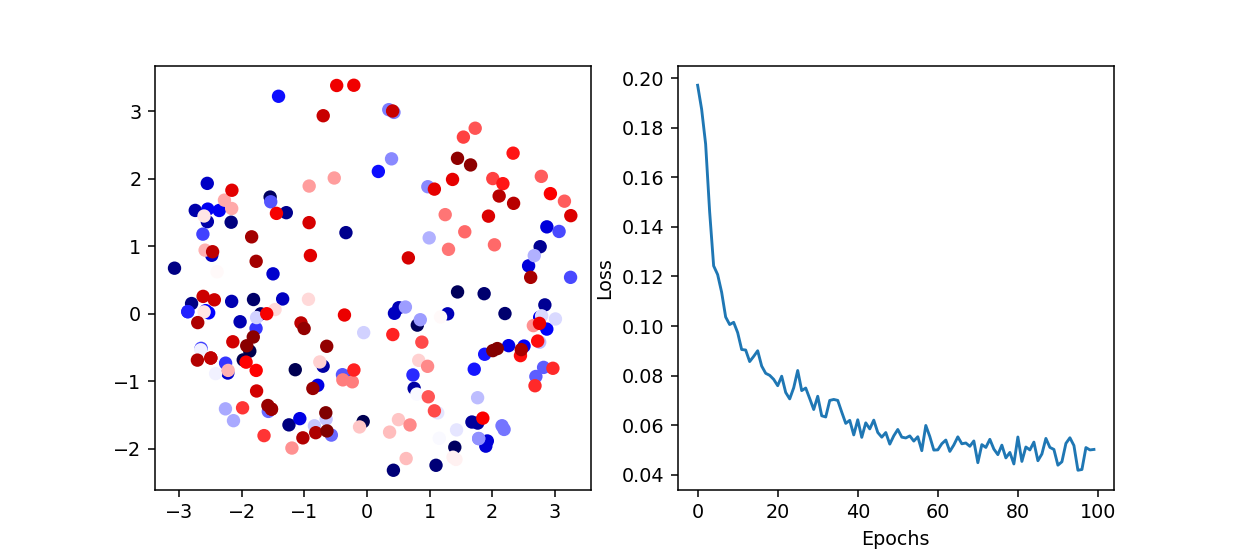

Epoch 1/100
3/3 [==============================] - 1s 232ms/step - loss: 0.1971
Epoch 2/100
3/3 [==============================] - 1s 220ms/step - loss: 0.1874
Epoch 3/100
3/3 [==============================] - 1s 194ms/step - loss: 0.1734
Epoch 4/100
3/3 [==============================] - 1s 203ms/step - loss: 0.1461
Epoch 5/100
3/3 [==============================] - 1s 215ms/step - loss: 0.1243
Epoch 6/100
3/3 [==============================] - 1s 216ms/step - loss: 0.1207
Epoch 7/100
3/3 [==============================] - 1s 211ms/step - loss: 0.1136
Epoch 8/100
3/3 [==============================] - 1s 200ms/step - loss: 0.1036
Epoch 9/100
3/3 [==============================] - 1s 208ms/step - loss: 0.1006
Epoch 10/100
3/3 [==============================] - 1s 212ms/step - loss: 0.1015
Epoch 11/100
3/3 [==============================] - 1s 190ms/step - loss: 0.0974
Epoch 12/100
3/3 [==============================] - 1s 190ms/step - loss: 0.0905
Epoch 13/100
3/3 [===================

In [230]:
%matplotlib notebook

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=True,
    callbacks=[PCAPlotter(plt, embedding_model,
                          np.reshape(X_images_test,(200,30000)), 
                          y_test)]
)